In [94]:
import numpy as np
import pandas as pd
import glob as gb
import re
import matplotlib.pyplot as plt
import pprint as pp
import os
from scipy import signal
from cycler import cycler
import lifetime as lf

%matplotlib notebook

# Helper Functions

In [95]:
def getSample(file):
    # Get smple name from file
    sample = os.path.basename(file)
    sample = os.path.splitext(sample)[0]
    return sample

def getSampleNo(file):
    # Get sample number 
    sample = os.path.basename(file)
    sample = os.path.splitext(sample)[0]
    # For files with underscore
    sample = sample.split('_')[0]
    return int(sample[1:])

# Lifetimes

In [96]:
# select files to analyse
files = gb.glob('./Lifetime/*.txt')
files = sorted(files, key=lambda x: getSampleNo(x))

In [91]:
# Select only T12 and T13
files = [x for x in files if '12' in x or '13' in x]

In [92]:
# Select the required pump
pump = 2
# Select only 100us pump
files = [x for x in files if '_2ms' in x]
files

['./Lifetime\\T12_2ms.txt', './Lifetime\\T13_2ms.txt']

<IPython.core.display.Javascript object>


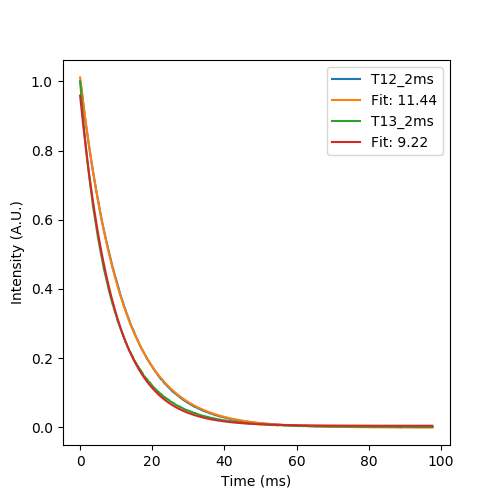

In [93]:
# Plot data
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for f in files:
    data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=10, usecols=(0,1))
    x = data[:,0]/1E6  # Convert time from us to ms
    y = data[:,1]
    
    x, y = lf.decay.drop_pump(x, y, pump=pump)
    x, y = lf.decay.reject(x, y, reject_end=100)
    x, y = lf.decay.normalise(x, y, point='start')
    
    # Plot raw data
    ax.plot(x, y, label=getSample(f))
    
    # Fit and plot
    popt = lf.decay.fit_decay(x, y)
    ax.plot(x, lf.decay.decay_fn(x, *popt), label='Fit: {:.2f}'.format(popt[1]))

# ax.set_yscale('log')
# plt.xlim(0, 100)
# plt.ylim(0.1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('Intensity (A.U.)')
plt.legend()

# ax.xaxis.set_ticks([0,10,20,30])

# plt.savefig('./Lifetime/plots/lifetime_' + getSample(f) + '.png', dpi=300)

# Spectrum

In [2]:
files = gb.glob('./Spectrum/PlottingData/*.txt')
files = sorted(files, key=lambda x: getSampleNo(x))

NameError: name 'getSampleNo' is not defined

In [17]:
# Select subset (optional)
files = [x for x in files if 'T2.' in x ]

<IPython.core.display.Javascript object>


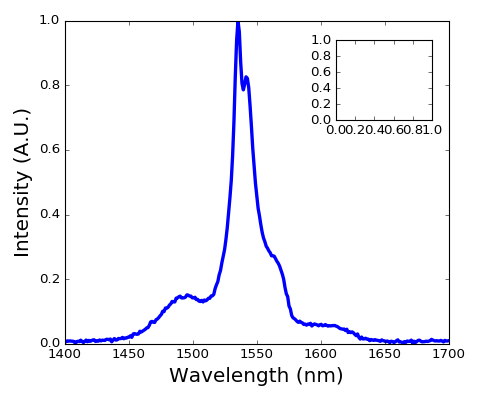

In [18]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

for f in files:
    # Load data
    data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=22, usecols=(0,1))
    wavelength = data[:,0]
    intensity = data[:,1]

    # Normalise
    intensity -= min(intensity)
    intensity /= max(intensity)

    ax.plot(wavelength, intensity, label=getSample(f), linewidth=3)

    # plt.legend()
    plt.xlabel('Wavelength (nm)', fontsize=18)
    plt.ylabel('Intensity (A.U.)', fontsize=18)
    plt.yticks(fontsize=12); 
    plt.xticks(fontsize=12)
    plt.xlim(min(wavelength),max(wavelength))
    plt.tight_layout()
    plt.savefig('./Spectrum/plots/spectrum_' + getSample(f) + '.png', dpi=300)

# Pandas Dataframe

In [3]:
# Get samples from file names
sample_list=[getSample(x) for x in files]

# Index
index = [int(x[1:]) for x in sample_list]

d = {'sample' : sample_list}

df = pd.DataFrame(d, index=index)
df.sort_index(inplace=True)
df = df.set_index('sample')

NameError: name 'files' is not defined

In [48]:
# Fit lifetime and add to dataframe
tau = []
sample = []
for f in files:
    data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=22, usecols=(0,1))
    time = data[:,0]/1E6  # Convert to ms
    intensity = data[:,1]
    
    # Sample
    sample.append(getSample(f))

    # Normalise
    intensity -= min(intensity)
    intensity /= max(intensity)

    # Shift time axis to account for the pump
    time -= 2*pump

    # Optional: drop the data before the pump
    ind = np.where(time>=0)
    time = time[ind]
    intensity = intensity[ind]
    
    tau.append(getLifetime(time, intensity, f))

df['Lifetime'] = pd.Series(tau, index=sample)  

In [49]:
df.head()

,MaxIntensity,TotalIntensity,Lifetime
sample,,,
T1,168200.0,15500290.0,12.582230
T2,165300.0,15583850.0,12.478841
T3,132600.0,14499530.0,12.041918
T4,160600.0,16723680.0,1.541385
T5,119400.0,14065800.0,12.971974


In [54]:
# Save Dataframe
df.to_csv('Spectrum_dataframe.csv')
# To load
# pd.read_csv('dataframe.csv', index_col=0) 